In [48]:
# !pip install plotly
import pandas as pd
# !pip install pandas_ta
import pandas_ta as ta
import numpy as np
import seaborn as sns
import datetime
from datetime import timedelta
import math
import requests
import plotly as py
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt

import sklearn as sk
import sklearn.preprocessing
from sklearn import metrics

from sklearn.preprocessing import  (StandardScaler, MinMaxScaler, LabelBinarizer)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, LogisticRegression
import xgboost as xgb
from sklearn.metrics import *
# from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import tree

from sklearn import decomposition
from sklearn.pipeline import Pipeline

# import chart_studio.tools as tls

In [49]:
#manipulatable variables
numDaysBack = str(365*5) #for daily you can go back multiple years worth, for daily you can only go back 90 days
myInterval = 'daily' # options are daily or hourly
theCoins = ['ethereum'] #can add more than one coin if you like
window_length = 14
mycom = 0.4
lower_macd_ema = 12
upper_macd_ema = 26
trigger_macd_ema = 9


def df_builder_clean(days, interval, coins, window, mycom, lower_macd_ema, upper_macd_ema, trigger_macd_ema):
    #manipulatable variables
    numDaysBack = days #for daily you can go back multiple years worth, for daily you can only go back 90 days
    myInterval = interval # options are daily or hourly
    theCoins = coins
    window_length = window

    #builds initial dataframe with ethereum as first market but just to log the dates we are working with
    geckoReq = 'https://api.coingecko.com/api/v3/coins/ethereum/market_chart?vs_currency=usd&days='+numDaysBack+'&interval='+myInterval+''
    r = requests.get(geckoReq).json()
    ts = r['prices'][0][0]
    ts = ts/1000
    HistPricesList = []
    for i in range(len(r['prices'])):
        currentUnix = r['prices'][i][0] 
        price = r['prices'][i][1]
        currentUnix = currentUnix/1000
#         currentTS = datetime.datetime.fromtimestamp(currentUnix).strftime("%d-%m-%Y %H:%M:%S") #adding dd-mm-yyyy hours minutes seconds
        currentTS = datetime.datetime.fromtimestamp(currentUnix).strftime("%m-%d-%Y") #just the date mm-dd-yyyy
        HistPricesList.append([currentTS])
    global df
    df = pd.DataFrame(HistPricesList, columns = ['date'])

    
    #looping through each coin and adding in all data points and input variables
    for coin in theCoins:
        price_data(coin)
        add_ewm(coin, mycom)
        add_rsi(coin, window_length)
        add_macd(coin, lower_macd_ema, upper_macd_ema, trigger_macd_ema)
        print('just added: ', coin)
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')
#     print('r')
#     display(r)
    return df


def price_data(coin):
    global df
    # geckoReq = 'https://api.coingecko.com/api/v3/coins/ethereum/market_chart?vs_currency=usd&days=60&interval=daily'
    geckoReq = 'https://api.coingecko.com/api/v3/coins/'+coin+'/market_chart?vs_currency=usd&days='+numDaysBack+'&interval='+myInterval+''

    r = requests.get(geckoReq).json()
    ts = r['prices'][0][0]
    # print(ts)
    ts = ts/1000
    print(datetime.datetime.fromtimestamp(ts).strftime("%m-%d-%Y"))
    # print('prices length',len(r['prices']))
    HistPricesList = []
    for i in range(len(r['prices'])):
        currentUnix = r['prices'][i][0] 
        price = r['prices'][i][1]
        volume = r['total_volumes'][i][1]
        currentUnix = currentUnix/1000
        currentTS = datetime.datetime.fromtimestamp(currentUnix).strftime("%m-%d-%Y")
    #     print('price: ', price, 'TS: ', currentTS)
        HistPricesList.append([currentTS, price, volume])
    #     currentUnix = currentTS
#         print(HistPricesList)
    dfCoin = pd.DataFrame(HistPricesList, columns = ['date', coin, coin+'_volume'])
#     print('dfCoin')
#     display(dfCoin)
    df = pd.merge(df, dfCoin[coin], left_on = df['date'], right_on=dfCoin['date']).drop(['key_0'], axis = 1)
    df = pd.merge(df, dfCoin[coin+'_volume'], left_on = df['date'], right_on=dfCoin['date']).drop(['key_0'], axis = 1)
    
def add_ewm(coin, mycom):
    df[coin+'_ewm'] = df[coin].ewm(com=mycom).mean()
    
def add_rsi(coin, window_length):
    global df
    df['diff'] = df[coin].diff(1)
    df['gain'] = df['diff'].clip(lower=0).round(2)
    df['loss'] = df['diff'].clip(upper=0).abs().round(2)
    
    # Get initial Averages
    df['avg_gain'] = df['gain'].rolling(window=window_length, min_periods=window_length).mean()[:window_length+1]
    df['avg_loss'] = df['loss'].rolling(window=window_length, min_periods=window_length).mean()[:window_length+1]

    # Get WMS averages
    # Average Gains
    for i, row in enumerate(df['avg_gain'].iloc[window_length+1:]):
        df['avg_gain'].iloc[i + window_length + 1] =\
            (df['avg_gain'].iloc[i + window_length] *
             (window_length - 1) +
             df['gain'].iloc[i + window_length + 1])\
            / window_length
    # Average Losses
    for i, row in enumerate(df['avg_loss'].iloc[window_length+1:]):
        df['avg_loss'].iloc[i + window_length + 1] =\
            (df['avg_loss'].iloc[i + window_length] *
             (window_length - 1) +
             df['loss'].iloc[i + window_length + 1])\
            / window_length
        
    df['rs'] = df['avg_gain'] / df['avg_loss']
    
    df['rsi'] = 100 - (100 / (1.0 + df['rs']))
    df = pd.DataFrame(df)
    df = df.drop(['gain', 'loss', 'avg_loss', 'avg_gain', 'rs'], axis = 1)
    
    #renaming diff and rsi columns
    dict = {'diff': coin+'_diff',
        'rsi': coin+'_rsi'}
    df.rename(columns=dict,
              inplace=True)

def add_macd(coin, lower_macd_ema, upper_macd_ema, trigger_macd_ema):
    global df
    #get ema for lower
    k = df[coin].ewm(span=lower_macd_ema, adjust = False, min_periods = lower_macd_ema).mean()

    #get ema for upper
    d = df[coin].ewm(span=upper_macd_ema, adjust=False, min_periods=upper_macd_ema).mean()

    macd = k-d
    
    # Get the 9-Day EMA of the MACD for the Trigger line
    macd_s = macd.ewm(span=trigger_macd_ema, adjust=False, min_periods=trigger_macd_ema).mean()
    # Calculate the difference between the MACD - Trigger for the Convergence/Divergence value
    macd_h = macd - macd_s
    # Add all of our new values for the MACD to the dataframe
    df['macd'] = df.index.map(macd)
    df['macd_h'] = df.index.map(macd_h)
    df['macd_s'] = df.index.map(macd_s)



mydf = pd.DataFrame(df_builder_clean(numDaysBack, myInterval, theCoins, window_length, mycom, lower_macd_ema, upper_macd_ema, trigger_macd_ema))
display(mydf)



07-20-2017


C:\Users\fooba\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


just added:  ethereum


ethereum  ethereum_volume  ethereum_ewm  ethereum_diff  \
date                                                                    
2017-07-20   217.086474     3.903940e+08    217.086474            NaN   
2017-07-21   231.143529     2.299701e+08    228.019739      14.057055   
2017-07-22   226.718599     2.044678e+08    227.068159      -4.424930   
2017-07-23   224.913407     1.442842e+08    225.518725      -1.805192   
2017-07-24   206.810505     3.580211e+08    212.130219     -18.102902   
...                 ...              ...           ...            ...   
2022-07-15  1234.099139     1.681719e+10   1214.297642      42.968302   
2022-07-16  1355.045640     1.902583e+10   1314.831927     120.946501   
2022-07-17  1344.720284     1.579765e+10   1336.180753     -10.325356   
2022-07-18  1570.658959     2.643729e+10   1503.665186     225.938675   
2022-07-19  1561.582296     2.817843e+10   1545.034550      -9.076663   

            ethereum_rsi       macd     macd_h     macd_s  
date                                                       
2017-07-20           NaN        NaN        NaN        NaN  
2017-07-21           NaN        NaN        NaN        NaN  
2017-07-22           NaN        NaN        NaN        NaN  
2017-07-23           NaN        NaN        NaN        NaN  
2017-07-24           NaN        NaN        NaN        NaN  
...                  ...        ...        ...        ...  
2022-07-15     51.511001 -47.361288  26.063357 -73.424645  
2022-07-16     59.079833 -28.343586  36.064847 -64.408433  
2022-07-17     58.243628 -13.944348  40.371268 -54.315616  
2022-07-18     68.684031  15.519614  55.868184 -40.348570  
2022-07-19     67.948750  37.702988  62.441247 -24.738258  

[1826 rows x 8 columns]

In [50]:
mydf.dropna(inplace=True)
myCols = ['ethereum', 'ethereum_volume', 'ethereum_ewm', 'ethereum_rsi', 'macd', 'macd_h', 'macd_s', 'ethereum_diff']

# swing column creator

In [93]:
swing_value = .1

mydf['pct_chg'] = mydf['ethereum_diff']/mydf['ethereum']
mydf['swing'] = (mydf['pct_chg']>swing_value).astype(int)
display(mydf.head(3))
print(mydf['swing'].value_counts())

ethereum  ethereum_volume  ethereum_ewm  ethereum_diff  \
date                                                                   
2017-08-22  316.788920     4.664746e+08    315.669228       4.614450   
2017-08-23  321.785298     3.977527e+08    320.037850       4.996378   
2017-08-24  329.025281     4.519507e+08    326.457443       7.239983   

            ethereum_rsi       macd    macd_h     macd_s   pct_chg  swing  
date                                                                       
2017-08-22     66.968053  20.299982 -0.506760  20.806742  0.014566      0  
2017-08-23     68.415202  20.485468 -0.257019  20.742487  0.015527      0  
2017-08-24     70.435010  20.974888  0.185921  20.788967  0.022004      0

0    1750
1      43
Name: swing, dtype: int64


In [52]:
mydf.corr()

ethereum  ethereum_volume  ethereum_ewm  ethereum_diff  \
ethereum         1.000000         0.532596      0.999823       0.031125   
ethereum_volume  0.532596         1.000000      0.533610      -0.039718   
ethereum_ewm     0.999823         0.533610      1.000000       0.013091   
ethereum_diff    0.031125        -0.039718      0.013091       1.000000   
ethereum_rsi     0.091199         0.234346      0.085413       0.234828   
macd             0.184958         0.278366      0.182728       0.073087   
macd_h          -0.001648        -0.111905     -0.007421       0.193804   
macd_s           0.196399         0.329698      0.195836       0.016988   
pct_chg          0.018557        -0.002291      0.006475       0.663776   
swing            0.013050         0.127843      0.006917       0.351217   

                 ethereum_rsi      macd    macd_h    macd_s   pct_chg  \
ethereum             0.091199  0.184958 -0.001648  0.196399  0.018557   
ethereum_volume      0.234346  0.278366 -0.111905  0.329698 -0.002291   
ethereum_ewm         0.085413  0.182728 -0.007421  0.195836  0.006475   
ethereum_diff        0.234828  0.073087  0.193804  0.016988  0.663776   
ethereum_rsi         1.000000  0.603675  0.395999  0.515891  0.349175   
macd                 0.603675  1.000000  0.331404  0.955767  0.058995   
macd_h               0.395999  0.331404  1.000000  0.039242  0.141460   
macd_s               0.515891  0.955767  0.039242  1.000000  0.018382   
pct_chg              0.349175  0.058995  0.141460  0.018382  1.000000   
swing                0.186546  0.074335  0.041832  0.065686  0.473029   

                    swing  
ethereum         0.013050  
ethereum_volume  0.127843  
ethereum_ewm     0.006917  
ethereum_diff    0.351217  
ethereum_rsi     0.186546  
macd             0.074335  
macd_h           0.041832  
macd_s           0.065686  
pct_chg          0.473029  
swing            1.000000

### Train test split

In [94]:
# X = my_data[['ethereum_volume', 'ethereum_ewm', 'ethereum_rsi', 'macd', 'ethereum_diff']]
X_raw = mydf[['ethereum_volume', 'ethereum_ewm', 'ethereum_rsi', 'macd', 'macd_h', 'macd_s']]
y = mydf['swing']
scaler=StandardScaler()
# Drop first row of prices
y.drop(index=y.index[0], 
        axis=0, 
        inplace=True)
#dropping last row of features
X_raw.drop(index=X_raw.index[-1], 
        axis=0, 
        inplace=True)
X=scaler.fit_transform(X_raw)
# display(X)
# X = X.shift(1, freq='d')
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .1, random_state=42)
X_train = X[:-360]
X_test = X[-360:]
y_train = y[:-360]
y_test = y[-360:]
print('X_train: ')
print(X_train.shape)
print('X_test: ')
print(X_test.shape)
print('y_train: ')
print(y_train.shape)
print('y_test: ')
print(y_test.shape)


X_train: 
(1432, 6)
X_test: 
(360, 6)
y_train: 
(1432,)
y_test: 
(360,)


C:\Users\fooba\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [ ]:
# focusing on optimizing precision because we want to increase true positives and decrease false positives

In [99]:

xgb_cl=xgb.XGBClassifier(objective='binary:logistic',colsample_bytree=0.75, learning_rate=0.1,
                        max_depth=5,alpha=10,n_estimators=10, scale_pos_weight= 22)
xgb_cl.fit(X_train,y_train, eval_metric="aucpr")

y_train_pred = xgb_cl.predict(X_train)
y_test_pred=xgb_cl.predict(X_test)


rmse_train=np.sqrt(mean_squared_error(y_train,y_train_pred))
rmse_test=np.sqrt(mean_squared_error(y_test,y_test_pred))

print('rmse_train: ', rmse_train)
print('rmse_test: ', rmse_test)

print('accuracy score of train: ' + str(accuracy_score(y_train, y_train_pred)))
print('accuracy score of test: ' + str(accuracy_score(y_test, y_test_pred)))

print("Precision train:",metrics.precision_score(y_train, y_train_pred))
print("Precision test:",metrics.precision_score(y_test, y_test_pred))

print("Recall train:",metrics.recall_score(y_train, y_train_pred))
print("Recall test:",metrics.recall_score(y_test, y_test_pred))

print('y_train confusion matrix')
print(confusion_matrix(y_train, y_train_pred))
print('y_test confusion matrix')
print(confusion_matrix(y_test, y_test_pred))
# print(['TN', 'FN'],'\n ',['FP', 'TP'])
print(['TN', 'FP'],'\n ',['FN', 'TP'])

rmse_train:  0.24075068817087233
rmse_test:  0.3073181485764296
accuracy score of train: 0.9420391061452514
accuracy score of test: 0.9055555555555556
Precision train: 0.30701754385964913
Precision test: 0.03125
Recall train: 0.8974358974358975
Recall test: 0.25
y_train confusion matrix
[[1314   79]
 [   4   35]]
y_test confusion matrix
[[325  31]
 [  3   1]]
['TN', 'FP'] 
  ['FN', 'TP']


C:\Users\fooba\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


In [100]:
parameters = {
    'max_depth': [4,6,8],
    'reg_lambda': [1,5,10],
    'booster': ['gbtree'],
    'colsample_bytree': [0.5, 0.75, 1],
#     'subsample': [0.4,0.75,1],
    'max_delta_step': [1,5,10],
    'scale_pos_weight': [25,50],
#     'n_estimators': range(0, 1000, 50),
    'n_estimators': [30,60,100],
#     'learning_rate': [0.1, 0.05]
    'eval_metric': ['aucpr']
}
grid_search = GridSearchCV(
    estimator=xgb_cl,
    param_grid=parameters,
#     scoring = 'roc_auc',
    n_jobs = 10,
    cv = 5,
    verbose=True
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 486 candidates, totalling 2430 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(alpha=10, base_score=0.5, booster='gbtree',
                                     callbacks=None, colsample_bylevel=1,
                                     colsample_bynode=1, colsample_bytree=0.75,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=0, gpu_id=-1,
                                     grow_policy='depthwise',
                                     importance_type=None,
                                     interaction_constraints='',
                                     learning_rate=0.1, max_bin=256,
                                     ma...
                                     monotone_constraints='()', n_estimators=10,
                                     n_jobs=0, num_parallel_tree=1,
                                     predictor='auto', random_state=0,
                         

In [101]:
print(grid_search.best_estimator_)
grid_search.best_estimator_.fit(X_train, y_train)
y_train_pred = grid_search.best_estimator_.predict(X_train)
y_test_pred = grid_search.best_estimator_.predict(X_test)

rmse_train=np.sqrt(mean_squared_error(y_train,y_train_pred))
rmse_test=np.sqrt(mean_squared_error(y_test,y_test_pred))

print('rmse_train: ', rmse_train)
print('rmse_test: ', rmse_test)

print('accuracy score of train: ' + str(accuracy_score(y_train, y_train_pred)))
print('accuracy score of test: ' + str(accuracy_score(y_test, y_test_pred)))

print("Precision train:",metrics.precision_score(y_train, y_train_pred))
print("Precision test:",metrics.precision_score(y_test, y_test_pred))

print("Recall train:",metrics.recall_score(y_train, y_train_pred))
print("Recall test:",metrics.recall_score(y_test, y_test_pred))

print('y_train confusion matrix')
print(confusion_matrix(y_train, y_train_pred))
print('y_test confusion matrix')
print(confusion_matrix(y_test, y_test_pred))
print(['TN', 'FP'],'\n ',['FN', 'TP'])

XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='aucpr', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=1, max_depth=8, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=60, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=10, ...)
rmse_train:  0.13731259448190453
rmse_test:  0.42491829279939874
accuracy score of train: 0.9811452513966481
accuracy score of test: 0.8194444444444444
Precision train: 0.5909090909090909
Precision test: 0.03076923076923077
Recall train: 1.0
Recall test: 0.5
y_train confusion matrix
[[1366   27]
 [   0   39

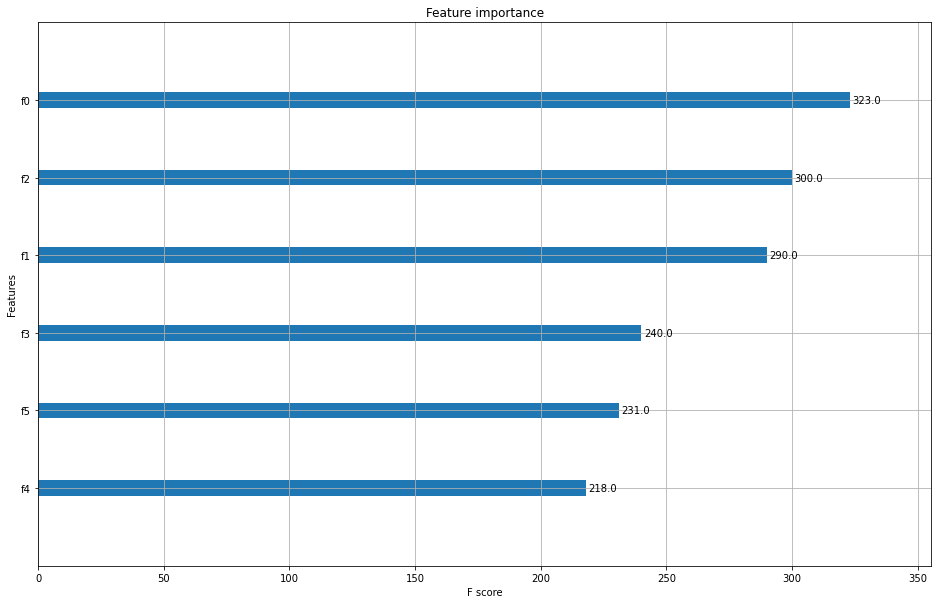

In [102]:
xgb.plot_importance(grid_search.best_estimator_)
plt.rcParams['figure.figsize']=[16,10]
plt.show()

In [ ]:
# train test split for decision tree

In [103]:
X_raw = mydf[['ethereum_volume', 'ethereum_ewm', 'ethereum_rsi', 'macd', 'macd_h', 'macd_s']]
y = mydf['swing']
scaler=StandardScaler()
# Drop first row of prices
y.drop(index=y.index[0], 
        axis=0, 
        inplace=True)
#dropping last row of features
X_raw.drop(index=X_raw.index[-1], 
        axis=0, 
        inplace=True)
X=scaler.fit_transform(X_raw)
display(X)
# X = X.shift(1, freq='d')
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .1, random_state=42)
X_train = X[:-60]
X_test = X[-60:]
y_train = y[:-60]
y_test = y[-60:]
print('X_train: ')
print(X_train.shape)
print('X_test: ')
print(X_test.shape)
print('y_train: ')
print(y_train.shape)
print('y_test: ')
print(y_test.shape)

C:\Users\fooba\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


array([[-0.89943038, -0.61369587,  1.10923284,  0.18594791, -0.01421085,
         0.20135522],
       [-0.90440643, -0.61012567,  1.21169983,  0.18804179, -0.00461809,
         0.20058703],
       [-0.90048204, -0.60487934,  1.35471457,  0.19356665,  0.0123956 ,
         0.20114272],
       ...,
       [ 0.44442157,  0.20285706,  0.55069884, -0.36316949,  1.39053618,
        -0.81742823],
       [ 0.21067423,  0.22030412,  0.49149037, -0.20062237,  1.55594952,
        -0.69676434],
       [ 0.98107287,  0.35717863,  1.23073456,  0.13198428,  2.15119946,
        -0.5297824 ]])

X_train: 
(1732, 6)
X_test: 
(60, 6)
y_train: 
(1732,)
y_test: 
(60,)


In [104]:
# print(y_train)
print(y_train.value_counts())
print(y_test.value_counts())

clf_d = tree.DecisionTreeClassifier(max_depth=4,
#                                     class_weight={0: 1, 1: 8},
                                    random_state=42
                                    )

clf_d = clf_d.fit(X_train, y_train)

y_train_pred = clf_d.predict(X_train)
y_test_pred = clf_d.predict(X_test)
# print
print(confusion_matrix(y_test, y_test_pred))
print('accuracy score of train: ' + str(accuracy_score(y_train, y_train_pred)))

print('accuracy score of test: ' + str(accuracy_score(y_test, y_test_pred)))
print('y_train confusion matrix')
print(confusion_matrix(y_train, y_train_pred))
print(['TN', 'FN'],'\n ',['FP', 'TP'])

0    1691
1      41
Name: swing, dtype: int64
0    58
1     2
Name: swing, dtype: int64
[[58  0]
 [ 2  0]]
accuracy score of train: 0.9786374133949192
accuracy score of test: 0.9666666666666667
y_train confusion matrix
[[1691    0]
 [  37    4]]
['TN', 'FN'] 
  ['FP', 'TP']


In [105]:
clf_c = tree.DecisionTreeClassifier(max_depth=4,
                                    # max_features='auto', 
                                    # max_leaf_nodes=None,
                                    # min_samples_leaf=1,
                                    # min_weight_fraction_leaf=0.1,
                                    # splitter='best',
                                    random_state=42
                                    )

clf_c.fit(X_train, y_train)
params={"splitter":["best"],
        "max_depth" : [1,2,3,4,5],
        "min_samples_leaf":[1,2,3,4,5,6,7],
        "min_weight_fraction_leaf":[0.1,0.25,0.5],
        "max_features":["auto","log2","sqrt",None],
        "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90]
        }
3
tuning_model=GridSearchCV(estimator=clf_c,param_grid=params,scoring='precision_macro',cv=3,verbose=3)
tuning_model.fit(X_train, y_train) 
tuning_model.best_params_

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

Fitting 3 folds for each of 4200 candidates, totalling 12600 fits
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.25, 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_de

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_feat

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_feat

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=90, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=90, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=90, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=90, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=90, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=90, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=90, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=90, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=90, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=90, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=90, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=90, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_de

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_de

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_feat

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=90, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=90, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=90, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=90, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=90, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=90, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=90, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=90, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=90, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=90, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=90, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=90, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_de

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_dept

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_feat

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_feat

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.2s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=90, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=90, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=90, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=90, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=90, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=90, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_de

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_feat

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=90, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=90, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=90, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=90, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=90, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=90, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=1, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=2, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_dept

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=2, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=2, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=2, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=2, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=2, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=2, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=2, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=2, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=2, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=2, max_feat

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=2, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=2, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=2, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=2, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=2, max_features=auto, max_leaf_nodes=90, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=auto, max_leaf_nodes=90, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=auto, max_leaf_nodes=90, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=auto, max_leaf_nodes=90, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=auto, max_leaf_nodes=90, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=auto, max_leaf_nodes=90, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=2, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=2, max_features=log2, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=log2, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=log2, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=log2, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=log2, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=log2, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_de

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=2, max_features=log2, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=log2, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=log2, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=log2, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=log2, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=log2, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=2, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=2, max_features=log2, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=log2, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=log2, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=log2, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=log2, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=log2, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=2, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=2, max_features=log2, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=log2, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=log2, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=log2, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=log2, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=log2, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=2, max_feat

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=2, max_features=log2, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=log2, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=log2, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=log2, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=log2, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=log2, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=2, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=2, max_features=log2, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=log2, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=log2, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=log2, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=log2, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=log2, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=2, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=2, max_features=log2, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=log2, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=log2, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=log2, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=log2, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=log2, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=2, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=2, max_features=log2, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=log2, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=log2, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=log2, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=log2, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=log2, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=2, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=2, max_features=log2, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=log2, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=log2, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=log2, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=log2, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=log2, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=2, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=2, max_features=log2, max_leaf_nodes=90, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=log2, max_leaf_nodes=90, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=log2, max_leaf_nodes=90, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=log2, max_leaf_nodes=90, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=log2, max_leaf_nodes=90, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=log2, max_leaf_nodes=90, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=2, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=2, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=2, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=2, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=2, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=2, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=2, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=2, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=90, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=90, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=90, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=90, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=90, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=90, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=2, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=2, max_features=None, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=None, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=None, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=None, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=None, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=None, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_dep

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=2, max_features=None, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=None, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=None, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=None, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=None, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=None, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=2, max_feat

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=2, max_features=None, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=None, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=None, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=None, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=None, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=None, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=2, max_feat

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=2, max_features=None, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=None, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=None, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=None, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=None, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=None, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=2, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=2, max_features=None, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=None, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=None, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=None, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=None, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=None, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=2, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=2, max_features=None, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=None, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=None, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=None, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=None, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=None, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=2, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=2, max_features=None, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=None, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=None, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=None, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=None, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=None, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=2, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=2, max_features=None, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=None, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=None, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=None, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=None, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=None, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=2, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=2, max_features=None, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=None, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=None, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=None, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=None, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=None, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=2, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=2, max_features=None, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=None, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=None, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=None, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=None, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=None, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=2, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=2, max_features=None, max_leaf_nodes=80, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=None, max_leaf_nodes=80, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=None, max_leaf_nodes=80, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=None, max_leaf_nodes=90, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=None, max_leaf_nodes=90, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=None, max_leaf_nodes=90, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=2, max_feat

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=2, max_features=None, max_leaf_nodes=90, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=None, max_leaf_nodes=90, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=None, max_leaf_nodes=90, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=None, max_leaf_nodes=90, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=None, max_leaf_nodes=90, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=None, max_leaf_nodes=90, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=2, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_de

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=3, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=3, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=3, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=3, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=3, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=3, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=3, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=3, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=90, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=90, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=90, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=90, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=90, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=90, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=3, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_dept

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=3, max_feat

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=3, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=3, max_feat

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=3, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=3, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=3, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=3, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=90, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=90, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=90, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=90, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=90, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=90, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=3, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_dep

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=3, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=3, max_feat

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=3, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=3, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=3, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=3, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=3, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=90, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=90, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=90, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=90, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=90, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=90, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=3, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=90, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=90, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=90, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=90, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=90, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=3, max_

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_de

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=3, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=3, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=3, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=3, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=3, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=3, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=3, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=3, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=3, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=3, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=90, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=90, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=90, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=90, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=90, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=90, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=3, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=4, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_dep

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=4, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=4, max_feat

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=4, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=4, max_feat

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=4, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=4, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=4, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=4, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=4, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=4, max_feat

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=4, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=4, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=4, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=4, max_feat

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=4, max_features=auto, max_leaf_nodes=80, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=auto, max_leaf_nodes=80, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=auto, max_leaf_nodes=80, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=auto, max_leaf_nodes=80, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=auto, max_leaf_nodes=80, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=auto, max_leaf_nodes=80, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=4, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=4, max_features=auto, max_leaf_nodes=90, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=auto, max_leaf_nodes=90, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=auto, max_leaf_nodes=90, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=auto, max_leaf_nodes=90, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=auto, max_leaf_nodes=90, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=auto, max_leaf_nodes=90, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=4, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=4, max_features=log2, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=log2, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=log2, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=log2, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=log2, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=log2, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=4, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=4, max_features=log2, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=log2, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=log2, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=log2, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=log2, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=log2, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=4, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=4, max_features=log2, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=log2, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=log2, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=log2, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=log2, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=log2, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=4, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=4, max_features=log2, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=log2, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=log2, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=log2, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=log2, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=log2, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=4, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=4, max_features=log2, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=log2, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=log2, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=log2, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=log2, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=log2, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=4, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=4, max_features=log2, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=log2, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=log2, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=log2, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=log2, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=log2, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=4, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=4, max_features=log2, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=log2, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=log2, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=log2, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=log2, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=log2, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=4, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=4, max_features=log2, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=log2, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=log2, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=log2, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=log2, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=log2, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=4, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=4, max_features=log2, max_leaf_nodes=80, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=log2, max_leaf_nodes=80, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=log2, max_leaf_nodes=90, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=log2, max_leaf_nodes=90, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=log2, max_leaf_nodes=90, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=log2, max_leaf_nodes=90, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=4, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_de

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=4, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=4, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=4, max_feat

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=4, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=4, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=4, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=4, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=4, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=90, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=90, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=90, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=90, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=90, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=90, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=4, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=4, max_features=None, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=None, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=None, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=None, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=None, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=None, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_de

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=4, max_features=None, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=None, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=None, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=None, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=None, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=None, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=4, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=4, max_features=None, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=None, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=None, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=None, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=None, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=None, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=4, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=4, max_features=None, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=None, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=None, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=None, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=None, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=None, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=4, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=4, max_features=None, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=None, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=None, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=None, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=None, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=None, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=4, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=4, max_features=None, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=None, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=None, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=None, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=None, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=None, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=4, max_feat

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=4, max_features=None, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=None, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=None, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=None, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=None, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=None, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=4, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=4, max_features=None, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=None, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=None, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=None, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=None, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=None, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=4, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=4, max_features=None, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=None, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=None, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=None, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=None, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=None, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=4, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=4, max_features=None, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=None, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=None, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=None, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=None, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=None, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=4, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=4, max_features=None, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=None, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=None, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=None, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=None, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=None, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=4, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=4, max_features=None, max_leaf_nodes=90, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=None, max_leaf_nodes=90, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=None, max_leaf_nodes=90, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=None, max_leaf_nodes=90, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=None, max_leaf_nodes=90, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=None, max_leaf_nodes=90, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=4, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_de

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=5, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=5, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=5, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=5, max_feat

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=5, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=5, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=5, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=90, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=90, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=90, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=90, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=90, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=90, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=5, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_de

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=5, max_feat

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=5, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=5, max_feat

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=5, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=5, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=5, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=5, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=90, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=90, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=90, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=90, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=90, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=90, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=5, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_dep

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=5, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=5, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=5, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=5, max_feat

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=5, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=5, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=5, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=90, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=5, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=90, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=90, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=5,

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_dept

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=5, max_feat

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=5, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=5, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=5, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=5, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=5, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=5, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=5, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=5, max_f

[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=90, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=90, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=90, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=90, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.488 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=90, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.488 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=90, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.489 total time=   0.0s
[CV 3/3] END max_depth=5, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

{'max_depth': 1,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_samples_leaf': 1,
 'min_weight_fraction_leaf': 0.1,
 'splitter': 'best'}

In [106]:
clf_c = tree.DecisionTreeClassifier(max_depth=1,
                                    max_features='auto', 
                                    max_leaf_nodes=None,
                                    min_samples_leaf=1,
                                    min_weight_fraction_leaf=0.1,
                                    splitter='best',
                                    random_state=42
                                    )

clf_c.fit(X_train, y_train)
y_train_pred = clf_c.predict(X_train)
y_test_pred = clf_c.predict(X_test)
print(confusion_matrix(y_test, y_test_pred))
print('accuracy score of test: ' + str(accuracy_score(y_test, y_test_pred)))

print(['TN', 'FP'],'\n ',['FN', 'TP'])

[[58  0]
 [ 2  0]]
accuracy score of test: 0.9666666666666667
['TN', 'FN'] 
  ['FP', 'TP']


In [141]:
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_we

In [107]:
logr = LogisticRegression(max_iter=10000)

logr = logr.fit(X_train,y_train)

y_test_pred = logr.predict(X_test)
y_train_pred = logr.predict(X_train)

print('ALPHA MODEL')
print('accuracy score of training: ' + str(accuracy_score(y_train, y_train_pred)))
print('accuracy score of test: ' + str(accuracy_score(y_test, y_test_pred)))
print('error score of training: ' + str(zero_one_loss(y_train, y_train_pred)))
print('error score of test: ' + str(zero_one_loss(y_test, y_test_pred)))
print()

print(['TN', 'FP'],'\n ',['FN', 'TP'])
print('training confusion matrix:')
print(confusion_matrix(y_train, y_train_pred))
print('test confusion matrix:')
print(confusion_matrix(y_test, y_test_pred))
print()
print('training precision:')
print(precision_score(y_train, y_train_pred))
print('test precision:')
print(precision_score(y_test, y_test_pred))
print('training recall:')
print(recall_score(y_train, y_train_pred))
print('test recall:')
print(recall_score(y_test, y_test_pred))
print('training f1:')
print(f1_score(y_train, y_train_pred))
print('test f1:')
print(f1_score(y_test, y_test_pred))

ALPHA MODEL
accuracy score of training: 0.9763279445727483
accuracy score of test: 0.9666666666666667
error score of training: 0.023672055427251704
error score of test: 0.033333333333333326

['TN', 'FP'] 
  ['FN', 'TP']
training confusion matrix:
[[1691    0]
 [  41    0]]
test confusion matrix:
[[58  0]
 [ 2  0]]

training precision:
0.0
test precision:
0.0
training recall:
0.0
test recall:
0.0
training f1:
0.0
test f1:
0.0


C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [108]:
pca = decomposition.PCA()

logr = LogisticRegression(max_iter=10000)

pipe = Pipeline(steps=[('pca', pca), ('logistic_Reg', logr)])

n_components = list(range(1,X_train.shape[1]+1,1))

C = np.logspace(-4, 4, 50)
penalty = ['l1', 'l2']

parameters = dict(pca__n_components=n_components,
                    logistic_Reg__C=C,
                    logistic_Reg__penalty=penalty)

clf_logr_gs = GridSearchCV(pipe, parameters)

clf_logr_gs.fit(X_train, y_train)

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
 0.9763289  0.9763289  0.9763289  0.9763289  0.9763289  0.9763289
        nan        nan        nan        nan        nan        nan
 0.9763289  0.9763289  0.9763289  0.9763289  0.9763289  0.9763289
        nan        nan        nan        nan        nan        nan
 0.9763289  0.9763289  0.9763289  0.9763289  0.9763289  0.9763289
        nan        nan        nan        nan        nan        nan
 0.9763289  0.9763289  0.9763289  0.9763289  0.9763289  0.9763289
        nan        nan        nan        nan        nan        nan
 0.9763289  0.9763289  0.9763289  0.9763289  0.9763289  0.9763289
        nan        nan        nan        nan        nan        nan
 0.9763289  0.9763289  0.9763289  0.9763289  0.9763289  0.9763289
        nan        nan        nan        nan        nan    

GridSearchCV(estimator=Pipeline(steps=[('pca', PCA()),
                                       ('logistic_Reg',
                                        LogisticRegression(max_iter=10000))]),
             param_grid={'logistic_Reg__C': array([1.00000000e-04, 1.45634848e-04, 2.12095089e-04, 3.08884360e-04,
       4.49843267e-04, 6.55128557e-04, 9.54095476e-04, 1.38949549e-03,
       2.02358965e-03, 2.94705170e-03, 4.29193426e-03, 6.25055193e-03,
       9.10298178e-03, 1.32571137e...
       3.72759372e+00, 5.42867544e+00, 7.90604321e+00, 1.15139540e+01,
       1.67683294e+01, 2.44205309e+01, 3.55648031e+01, 5.17947468e+01,
       7.54312006e+01, 1.09854114e+02, 1.59985872e+02, 2.32995181e+02,
       3.39322177e+02, 4.94171336e+02, 7.19685673e+02, 1.04811313e+03,
       1.52641797e+03, 2.22299648e+03, 3.23745754e+03, 4.71486636e+03,
       6.86648845e+03, 1.00000000e+04]),
                         'logistic_Reg__penalty': ['l1', 'l2'],
                         'pca__n_components': [1, 2, 3,

In [109]:
print('Best Penalty:', clf_logr_gs.best_estimator_.get_params()['logistic_Reg__penalty'])
print('Best C:', clf_logr_gs.best_estimator_.get_params()['logistic_Reg__C'])
print('Best Number Of Components:', clf_logr_gs.best_estimator_.get_params()['pca__n_components'])
print(); print(clf_logr_gs.best_estimator_.get_params()['logistic_Reg'])


Best Penalty: l2
Best C: 0.0001
Best Number Of Components: 1

LogisticRegression(C=0.0001, max_iter=10000)


In [145]:
clf_logr_gs.best_estimator_.get_params()

{'memory': None,
 'steps': [('pca', PCA(n_components=5)),
  ('logistic_Reg',
   LogisticRegression(C=0.009102981779915217, max_iter=10000))],
 'verbose': False,
 'pca': PCA(n_components=5),
 'logistic_Reg': LogisticRegression(C=0.009102981779915217, max_iter=10000),
 'pca__copy': True,
 'pca__iterated_power': 'auto',
 'pca__n_components': 5,
 'pca__random_state': None,
 'pca__svd_solver': 'auto',
 'pca__tol': 0.0,
 'pca__whiten': False,
 'logistic_Reg__C': 0.009102981779915217,
 'logistic_Reg__class_weight': None,
 'logistic_Reg__dual': False,
 'logistic_Reg__fit_intercept': True,
 'logistic_Reg__intercept_scaling': 1,
 'logistic_Reg__l1_ratio': None,
 'logistic_Reg__max_iter': 10000,
 'logistic_Reg__multi_class': 'auto',
 'logistic_Reg__n_jobs': None,
 'logistic_Reg__penalty': 'l2',
 'logistic_Reg__random_state': None,
 'logistic_Reg__solver': 'lbfgs',
 'logistic_Reg__tol': 0.0001,
 'logistic_Reg__verbose': 0,
 'logistic_Reg__warm_start': False}